![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 16 - Bagging

Los *ensembles* (https://en.wikipedia.org/wiki/Ensemble_learning) son métodos que utilizan varios modelos para obtener un modelo más poderoso.

Son muchos los métodos existentes para combinar modelos, pero hay dos que han destacado por su buen rendimiento:
- Bagging y
- Boosting

En esta sesión nos centraremos en el **Bagging** y en la próxima sesión en el Boosting.

Ya hemos comentado en sesiones pasadas que uno de los problemas a los que debemos enfrentarnos es la posibilidad de que nuestros modelos se sobreajusten. Una forma de abordar este problema es mediante el bagging.

La idea detrás del bagging es muy sencilla: se entrenarán muchos clasificadores utilizando particiones del conjunto de datos ligeramente diferentes y se combinarán las salidas de todos ellos para obtener la predicción final. Al tener muchos modelos, unos se sobreajustarán en unas zonas del espacio y otros modelos lo harán en otras zonas, pero esos sobreajustes perderán fuerza en la combinación final de todos los modelos. Por tanto, **el bagging busca reducir la varianza**.

Vamos a cargar un conjunto de datos para poder ir haciendo pruebas.

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

print('\n##########################################')
print('### cargar el conjunto y separar X e y')
print('##########################################')

# se llama a la función read_csv
# no tiene missing y las columnas están separadas por ','. Tiene cabecera
df = pd.read_csv('heart_failure_clinical_records_dataset.csv', header=0)
filas, columnas = df.shape

# la clase está en la última columna 
# separamos los atributos y los almacenamos en X
X = df.iloc[:,0:(columnas-1)]

# separamos la clase y la almacenamos en Y
y = df.iloc[:,(columnas-1)]

print('\n##########################################')
print('### Hold-out 70-30')
print('##########################################')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)


##########################################
### cargar el conjunto y separar X e y
##########################################

##########################################
### Hold-out 70-30
##########################################


# 16.1 `BaggingClassifier`
 
Para aplicar bagging es necesario crear varios conjuntos de entrenamiento diferentes. Como solo tenemos un conjunto de entrenamiento, la manera de crear varios conjuntos será mediante un muestreo con reemplazamiento (Bootstrap AGGregatING, de ahí el nombre de Bagging).

Si tenemos 100 ejemplos y, a partir de esos ejemplos, creamos 10 conjuntos de 100 ejemplos aplicando muestreo con reemplazamiento, tendremos que en cada conjunto habrá ejemplos repetidos y, además, en algunos de los conjuntos no aparecerá alguno de los ejemplos originales. Por tanto, estos conjuntos serán bastante similares, pero tendrán ciertas diferencias.

Con cada uno de esos conjuntos se entrenará un modelo utilizando el algoritmo que nos interese (por ejemplo la regresión logística). Para aumentar las diferencias entre estos modelos podemos también hacer que cada modelo, en lugar de utilizar todos los atributos del conjunto, utilice un subconjunto de los mismos.

Así que estamos entrenando cada modelo con un conjunto de ejemplos en el que faltarán algunos de los ejemplos y otros estarán repetidos y, además, les estaremos ocultando algunos de los atributos. Por estas razones, estos modelos están en cierta manera debilitados.

Es importante destacar que cada entrenamiento es independiente de los demás y, por tanto, **utilizando bagging se pueden realizar todos los entrenamientos de los modelos en paralelo.**

Para clasificar un ejemplo se obtendrán las predicciones de todos los modelos y se combinarán para obtener la predicción final. Si los modelos se han generado utilizando un algoritmo que pueda producir probabilidades, entonces se promediarán las probabilidades obtenidas por cada clase y la que obtenga el mayor valor será la clase predicha. Si el algoritmo base no tiene `predict_proba()` entonces se recurrirá a una simple votación.

Veamos al `BaggingClassifier` en funcionamiento:

In [2]:
# regresión logística
std_lr = Pipeline([('std', StandardScaler()), ('lr', LogisticRegression())])
std_lr.fit(X_train, y_train) 
y_pred = std_lr.predict(X_test)
print("Reglog     -      Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# bagging con regresión logística
sys_bag_rl = BaggingClassifier(base_estimator=std_lr, random_state=1234, n_jobs=-1)
sys_bag_rl.fit(X_train, y_train) 
y_pred = sys_bag_rl.predict(X_test)
print("Bagging(RegLog) - Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

Reglog     -      Accuracy: 0.8222
Bagging(RegLog) - Accuracy: 0.8333


Hemos ejecutado ambos algoritmos con sus hiperparámetros por defecto y vemos que el bagging ya obtiene un mejor resultado.

Hay varios hiperparámetros sobre los que se puede actuar, pudiendo destacarse:
- `base_estimator`, el algoritmo base que utilizaremos
- `n_estimators`, número de modelos que se entrenarán
- `max_samples`, ratio o número de ejemplos que tendrá cada cada muestra del conjunto de entrenamiento
- `max_features`, ratio o número de atributos que se utilizarán en cada muestra del conjunto de entrenamiento

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Vamos a ver cómo afecta el número máximo de atributos que se permite utilziar a cada modelo:

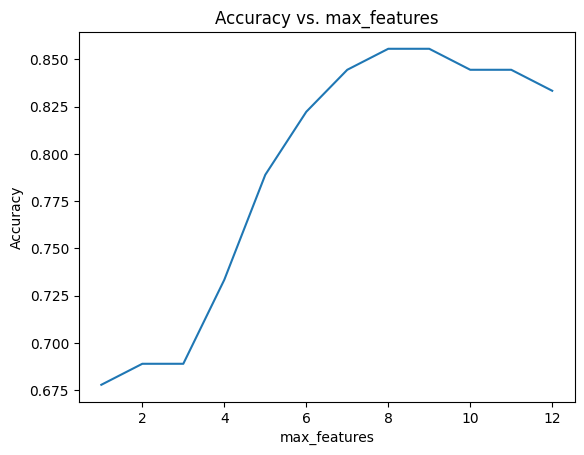

In [3]:
# obtenemos el número de atributos
(num_ejemplos, num_atributos) = X.shape 

# almacenamos todos los resultados en un vector
scores = np.zeros(num_atributos, dtype=np.float32)

for mf in range(1,num_atributos+1):
    sys_bag_rl.set_params(max_features=mf)   # cambiamos el número máximo de atributos
    sys_bag_rl.fit(X_train, y_train)         # entrenamos
    y_pred = sys_bag_rl.predict(X_test)      # evaluamos
    scores[mf-1] = metrics.accuracy_score(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(range(1,num_atributos+1), scores)
ax.set_title('Accuracy vs. max_features')
ax.set_xlabel('max_features')
ax.set_ylabel('Accuracy')
plt.show()

Como vemos, es un hiperparámetro muy sensible que se debería optimizar.

# 16.1 RandomForest

Vimos en sesiones anteriores que los árboles de decisión extienden sus ramas lo necesario para tratar de clasificar correctamente todos los ejemplos de entrenamiento y esto, en ocasiones, les lleva al sobreajuste. 

`RandomForest` es un algoritmo que realiza bagging utilizando árboles de decisión. Suele ofrecer muy buen rendimiento y por eso es ampliamente utilizado.

Veamos su rendimiento en este mismo conjunto de datos:

In [4]:
# árbol de decisión
sys_dt = DecisionTreeClassifier(random_state=1234)
sys_dt.fit(X_train, y_train) 
y_pred = sys_dt.predict(X_test)
print("Árbol de decisión - Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# random forest
sys_rf = RandomForestClassifier(random_state=1234, n_jobs=-1)
sys_rf.fit(X_train, y_train) 
y_pred = sys_rf.predict(X_test)
print("RandomForest   -    Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

Árbol de decisión - Accuracy: 0.7667
RandomForest   -    Accuracy: 0.8667


Hemos utilizado los hiperparámetros por defecto de la clase `RandomForestClassifier` y vemos que los resultados han mejorado bastante.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier 

En la documentación podemos ver que hay hiperparámetros muy relacionados con los árboles de decisión, por ejemplo, utilizando `max_depth` podemos limitar la profundidad de los árboles que se aprenden, debilitando aún más los clasificadores débiles.

# 16.1.1 Relevancia de los atributos

Una de las razones por las que gustan mucho los árboles de decisión es por su capacidad para explicar su modelo a través de un árbol comprensible por los humanos y eso es algo que no se puede tener utilizando random forest. La razón es que ya no tenemos un solo árbol, sino que tenemos decenas o cientos de árboles.

Sin embargo, sí que podemos obtener una medida de la relevancia de los atributos en función de su intervención en los árboles. Esa información podemos obtenerla consultando el atributo `feature_importances_` despues de entrenar el algoritmo.

Vamos a representar esas relevancias en un gráfico:

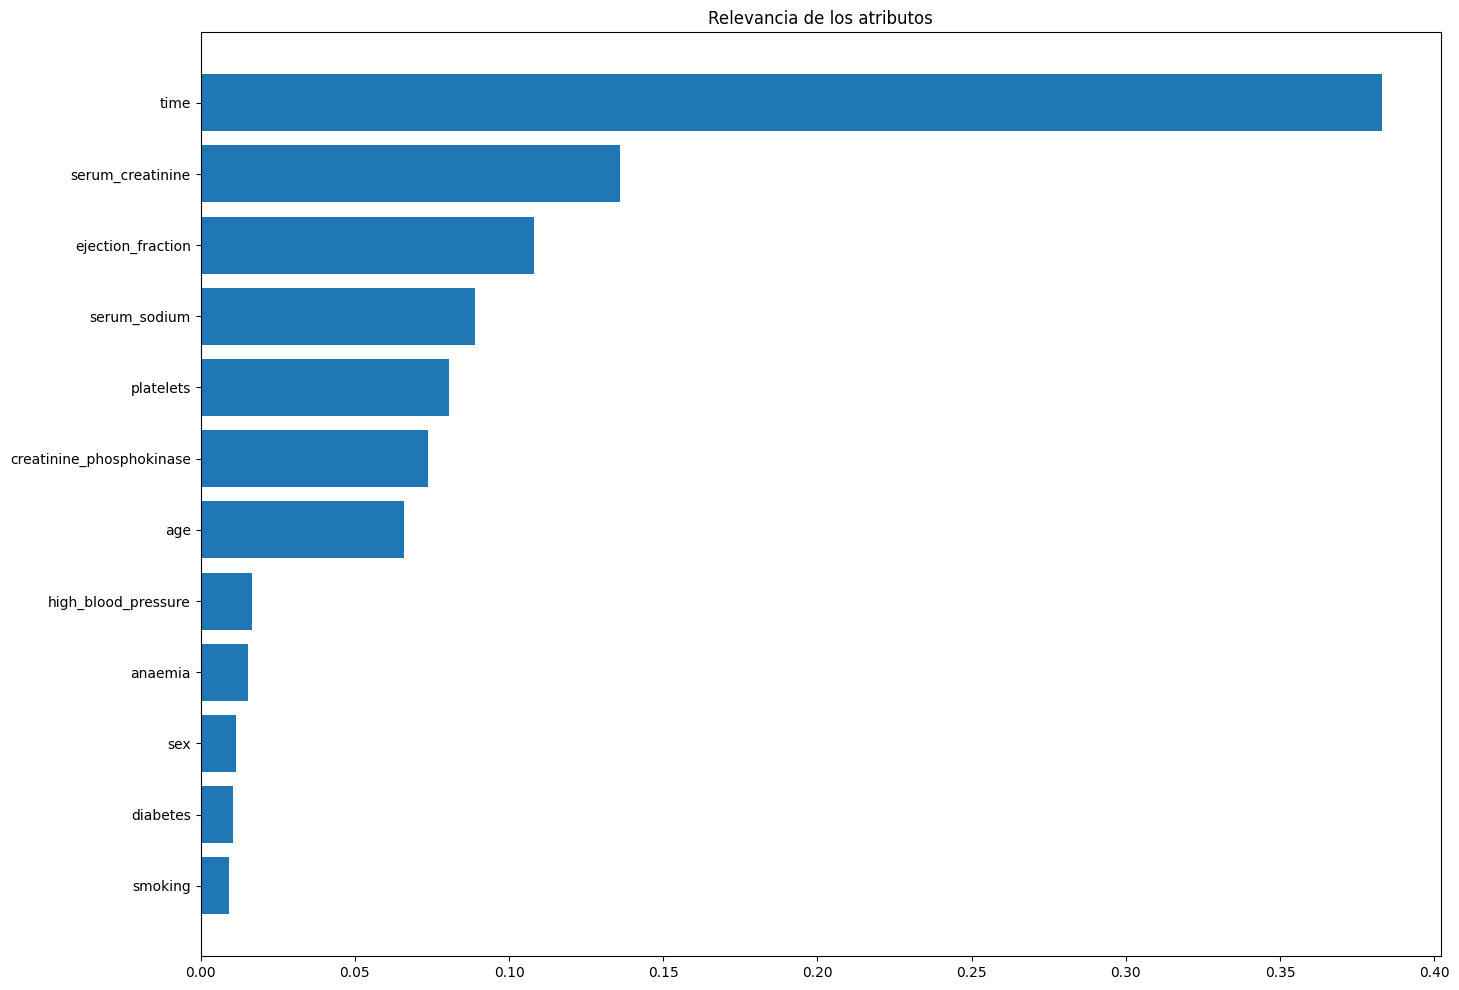

In [5]:
importances = sys_rf.feature_importances_

# ordenamos los atributos en orden descendente de importancia
indices = np.argsort(importances)[::-1]

# los representamos gráficamente
fig, ax = plt.subplots()
fig.set_size_inches((16,12))
ax.set_title("Relevancia de los atributos") 
# [::-1] para que aparezcan en orden decreciente en la gráfica
ax.barh(range(num_atributos), importances[indices[::-1]], tick_label=X.columns[indices[::-1]]) 
plt.show()


Vemos que en este problema hay un atributo que destaca por su alta relevancia y 5 atributos muy poco relevantes.

Las relevancias están normalizadas de tal manera que la suma de todas ellas es 1.

## Ejercicios

1. Carga el fichero **biodeg.data** (es un archivo de texto). 
2. Separa el conjunto en un 70% para entrenar y un 30% para test
3. Obten resultados utilizando Regresión Logística, árboles de decisión y utilizando bagging
4. Representa la relevancia de los atributos
5. Repite lo mismo con el conjunto **ionosphere.data**

Estos ejercicios no es necesario entregarlos.